# pipegraph User Guide

## Rationale

[scikit-learn](http://scikit-learn.org/stable/) provides a useful set of data preprocessors and machine learning models. The `Pipeline` object can effectively encapsulate a chain of transformers followed by final model. Other functions, like `GridSearchCV` can effectively use `Pipeline` objects to find the set of parameters that provide the best estimator.

#### Pipeline + GridSearchCV: an awesome combination
Let's consider a simple example to illustrate the advantages of using `Pipeline` and `GridSearchCV`.

First let's import the libraries we will use and then let's build some artificial data set following a simple polynomial rule

In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

X = 2*np.random.rand(100,1)-1
y = 40 * X**5 + 3*X*2 +  3*X + 3*np.random.randn(100,1)

Once we have some data ready, we instantiate the transformers and a regressor we want to fit:

In [22]:
scaler = MinMaxScaler()
polynomial_features = PolynomialFeatures()
linear_model = LinearRegression()

We define the steps that form the Pipeline object and then we instantiate such a Pipeline

In [23]:
steps = [('scaler', scaler),
         ('polynomial_features', polynomial_features),
         ('linear_model', linear_model)]

pipe = Pipeline(steps=steps)

Now we can pass this pipeline to `GridSearchCV`. When the `GridSearchCV` object is fitted, the search for the best combination for hyperparameters is performed according to the values provided in the `param_grid` parameter:

In [24]:
param_grid = {'polynomial_features__degree': range(1, 11),
              'linear_model__fit_intercept': [True, False]}

grid_search_regressor = GridSearchCV(estimator=pipe, param_grid=param_grid, refit=True)
grid_search_regressor.fit(X, y);

And now we can check the results of fitting the Pipeline and the values of the hyperparameters:

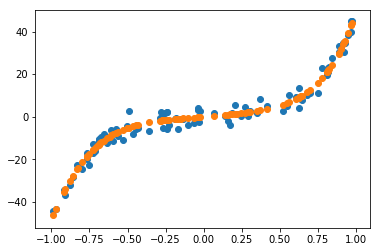

In [25]:
y_pred = grid_search_regressor.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred)
plt.show()

In [26]:
coef = grid_search_regressor.best_estimator_.get_params()['linear_model'].coef_
degree = grid_search_regressor.best_estimator_.get_params()['polynomial_features'].degree

print('Information about the parameters of the best estimator: \n degree: {} \n coefficients: {} '.format(degree, coef))

Information about the parameters of the best estimator: 
 degree: 6 
 coefficients: [[  -46.13066962   343.32162766 -1015.54326464  1304.6951907   -272.53210185
   -866.59140176   596.73121328]] 


#### Pipeline weaknesses:
From this example we can learn that `Pipeline` and `GridSearchCV` are very useful tools to consider when attempting to fit models. As far as the needs of the user can be satisfied by a set of transformers followed by a final model, this approach seems to be highly convenient. Additional advantages of such approach are the **parallel computation** and **memoization** capabilities of GridSearchCV.

Unfortunately though, current implementation of scikit-learn's `Pipeline`:
- Does not allow postprocessors after the final model
- Does not allow extracting information about intermediate results
- The X is transformed on every transformer but the following step can not have access to X variable values beyond the previous step
- Does not allow non linear workflows

#### pipegraph goals:
[pipegraph](https://github.com/mcasl/PipeGraph) was programmed in order to allow researchers and practitioners to:
- Use non linear workflows
- Have access to every variable value produced by any step of the workflow
- Use an arbitraty number of models and transformers in the way the user prefers
- Express the model as a graph consisting of transformers, regressors, classifiers or custom blocks
- Build new custom block in an easy way

## Description of the library

### Main interface: The PipeGraphRegressor and PipeGraphClassifier classes
`pipegraph` provides the user two main classes: `PipeGraphRegressor` and `PipeGraphClassifier`. They both provide a familiar interface to the raw `PipeGraph` class that most users will not need to use. The `PipeGraph` class provides greater versatility allowing an arbitrary number of inputs and outputs and may be the base class for those users facing applications with such special needs. Most users, though, will be happy using just the former two classes provided as main interface to operate the library.

As the names intend to imply, `PipeGraphRegressor` is the class to use for regression models and `PipeGraphClassifier` is intended for classification problems. Indeed, the only difference between these two classes is the default scoring function that has been chosen accordingly to scikit-learn defaults for each case. Apart from that, both classes share the same code. It must be noticed though, that any of these classes can comprise a plethora of different regressors or clasiffiers. It is the final step the one that will define whether we are defining a classification or regression problem.

### From a linear workflow to a graph: Understanding connections
Theses two classes provide an interface as similar to scikit-learn's `Pipeline` as possible in order to ease their use to those already familiar with scikit-learn. There is a slight but important difference that empowers these two classes: the `PipeGraph` related classes accept extra information about which input variables are needed by each step, thus allowing non linear workflows. 

To clarify the usage of these connections, let's start using `pipegraph` with a simple example that could be otherwise perfectly expressed using a scikit-learn's `Pipeline` as well. In this simple case, the data is transformed using a `MinMaxScaler` transformer and the preprocessed data is fed to a `LinearRegression` model. Figure 1 shows the steps of this PipeGraphRegressor and the connections between them: which input variables each one accepts and their origin, that is, if they are provided by a previous step, like the output of `scaler`, named `predict`, that is used by `linear_model`'s `X` variable; or `y` which is not calculated by any previous block but is passed by the user in the `fit` or `predict` method calls.

<img src="https://raw.githubusercontent.com/mcasl/PipeGraph/master/doc/images/figure1.png" width="400" />
Figure 1. PipeGraph diagram showing the steps and their connections

In this first simple example of `pipegraph` the last step is a regressor, and thus the `PipeGraphRegressor` class is the most adequate class to choose. But other than that, we define the steps as usual for a standard `Pipeline`: as a list of tuples (label, sklearn object). We are not introducing yet any information at all about the connections, in which case the `PipeGraphRegressor` object is built considering that the steps follow a linear workflow in the same way as a standard `Pipeline`.

In [18]:
from pipegraph import PipeGraphRegressor

scaler = MinMaxScaler()
linear_model = LinearRegression()
steps = [('scaler', scaler),
         ('linear_model', linear_model)]

pgraph = PipeGraphRegressor(steps=steps)
pgraph.fit(X, y)

PipeGraphRegressor(fit_connections={'scaler': {'X': 'X'}, 'linear_model': {'X': ('scaler', 'predict'), 'y': 'y'}},
          log_level=None,
          predict_connections={'scaler': {'X': 'X'}, 'linear_model': {'X': ('scaler', 'predict'), 'y': 'y'}},
          steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('linear_model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

As the printed output shows, the internal links displayed by the `fit_connections` and `predict_connections` parameters are in line with those we saw in Figure 1 and those expected by a linear pipeline. As we did not specify these values, they were created by `PipeGRaphRegressor.__init__()` method as a comodity. We can have a look at these values by directly inspecting the attributes values. As `PipeGraphRegressor` and `PipeGraphClassifier` are wrappers of a `PipeGraph` object stored in the `_pipegraph` attribute, we have to dig a bit deeper to find the `fit_connections`

In [19]:
pgraph._pipegraph.fit_connections

{'linear_model': {'X': ('scaler', 'predict'), 'y': 'y'}, 'scaler': {'X': 'X'}}

Figure 2 surely will help understading the syntax used by the connections dictionary. It goes like this:
- The keys of the top level entries of the dictionary must be the same as those of the previously defined steps.
- The values assocciated to these keys define the variables from other steps that are going to be considered as inputs for the current step. They are dictionaries themselves, where:

   - The keys of the nested dictionary represent the input variables as named at the current step.
   - The values assocciated to these keys define the steps that hold the desired information and the variables as named at that step. This information can be written as:

     - A tuple with the label of the step in position 0 followed by the name of the output variable in position 1.
     - A string:
         - If the string value is one of the labels from the steps, then it is interpreted as tuple, as previously, with the label of the step in position 0 and 'predict' as name of the output variable in position 1.
         - Otherwise, it is considered to be a variable from an external source, such as those provided by the user while invoking the ``fit``, ``predict`` or ``fit_predict`` methods.


![Figure 2. Illustration of the connections of the PipeGraph](https://raw.githubusercontent.com/mcasl/PipeGraph/master/examples/images/Diapositiva1-2.png)

Figure 2. Illustration of the connections of the PipeGraph

The choice of name 'predict' for default output variables was made for convenience reasons as it will be illustrated later on. The developers preferred using always the same word for every block even though it might not be a regressor nor a classifier.

Finally, let's get the predicted values from this `PipeGraphRegressor` for illustrative purposes:

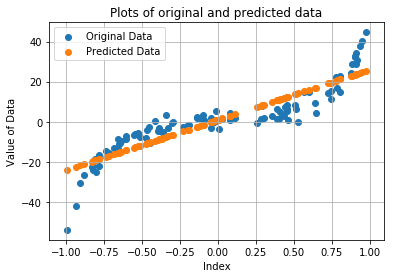

In [20]:
y_pred = pgraph.predict(X)
plt.scatter(X, y, label='Original Data')
plt.scatter(X, y_pred, label='Predicted Data')
plt.title('Plots of original and predicted data')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Index')
plt.ylabel('Value of Data')
plt.show()

### `GridSearchCV` compatibility

Both `PipeGraphRegressor`and `PipeGraphClassifier` are compatible with `GridSearchCV` provided the last step can be scored, either:
- by using `PipeGraphRegressor` or `PipeGraphClassifier` default scoring functions,
- by implementing a custom scoring function capable of handling that last step inputs and outputs,
- by using a `NeutralRegressor` or `NeutralClassifier` block as final step.

Those pipegraphs with a last step from scikit-learn's estimators set will work perfectly well using `PipeGraphRegressor` or `PipeGraphClassifier` default scoring functions. The other two alternative cover those cases in which a custom block with non standard inputs is provided. In that case, choosing a neutral regressor or classifier is usually a much simpler approach than writing customs scoring function. `NeutralRegressor` or `NeutralClassifier` are two classes provided for users convenience so that no special scoring function is needed. They just allow the user to pick some variables from other previous steps as `X` and `y` and provide compatibility to use a default scoring function.  

We will show more complex examples in what follows, but let's first illustrate with a simple example how to use `GrisSearchCV` with the default scoring functions.
This example shows how to use `GridSearchCv` with **PipeGraph** to effectively fit the best model across a number of hyperparameters. I is equivalent to use `GridSearchCv` with `Pipeline`. More complicated cases are shown in the following examples. In this second example we wanted to show how to fit a `GridSearchCV` in a yet simple scenario.

Steps of the **PipeGraph**:

- **scaler**: a preprocessing step using a :class:`MinMaxScaler` object
- **polynomial_features**: a transformer step
- **linear_model**: the :class:`LinearRegression` object we want to fit and use for predict.

.. figure:: https://raw.githubusercontent.com/mcasl/PipeGraph/master/examples/images/Diapositiva2.png

    Figure 1. PipeGraph diagram showing the steps and their connections

Firstly, we import the necessary libraries and create some artificial data.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from pipegraph.base import PipeGraphRegressor

import matplotlib.pyplot as plt

X = 2*np.random.rand(100,1)-1
y = 40 * X**5 + 3*X*2 +  3*X + 3*np.random.randn(100,1)

scaler = MinMaxScaler()
polynomial_features = PolynomialFeatures()
linear_model = LinearRegression()

Secondly, we define the steps and a ``param_grid`` dictionary as specified by :class:`GridSearchCV`.
In this case we just want to explore a few possibilities varying the degree of the polynomials and whether to use or not an intercept at the linear model.

In [ ]:
steps = [('scaler', scaler),
         ('polynomial_features', polynomial_features),
         ('linear_model', linear_model)]

param_grid = {'polynomial_features__degree': range(1, 11),
              'linear_model__fit_intercept': [True, False]}

Now, we use ``PipeGraphRegressor`` as estimator for :class:`GridSearchCV` and perform the ``fit`` and ``predict`` operations.

In [ ]:
pgraph = PipeGraphRegressor(steps=steps)
grid_search_regressor = GridSearchCV(estimator=pgraph, param_grid=param_grid, refit=True)
grid_search_regressor.fit(X, y)
y_pred = grid_search_regressor.predict(X)

plt.scatter(X, y)
plt.scatter(X, y_pred)
plt.show()


coef = grid_search_regressor.best_estimator_.get_params()['linear_model'].coef_
degree = grid_search_regressor.best_estimator_.get_params()['polynomial_features'].degree

print('Information about the parameters of the best estimator: \n degree: {} \n coefficients: {} '.format(degree, coef))

This example showed how to use :class:`GridSearchCV` with :class:`PipeGraphRegressor` in a simple linear workflow.
:ref:`Next example <example3>` provides detail on how to proceed with a non linear case.

### Wrappers for Scikit-Learn standard objects
Consider the following Scikit-Learn common objects:

In [17]:
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

classifier = GaussianNB()
scaler = MinMaxScaler() 
dbscanner = DBSCAN()

And let's load some data to run the examples:

In [132]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

Now, let's fit each of the above defined sklearn objects and get the output produced afterwards by using the corresponding method (predict, fit_predict, transform):

In [133]:
classifier.fit(X, y)
scaler.fit(X);
dbscanner.fit(X, y)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [134]:
classifier.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [135]:
classifier.predict_proba(X)

array([[  1.00000000e+000,   1.38496103e-018,   7.25489025e-026],
       [  1.00000000e+000,   1.48206242e-017,   2.29743996e-025],
       [  1.00000000e+000,   1.07780639e-018,   2.35065917e-026],
       [  1.00000000e+000,   1.43871443e-017,   2.89954283e-025],
       [  1.00000000e+000,   4.65192224e-019,   2.95961100e-026],
       [  1.00000000e+000,   1.52598944e-014,   1.79883402e-021],
       [  1.00000000e+000,   1.13555084e-017,   2.79240943e-025],
       [  1.00000000e+000,   6.57615274e-018,   2.79021029e-025],
       [  1.00000000e+000,   9.12219356e-018,   1.16607332e-025],
       [  1.00000000e+000,   3.20344249e-018,   1.12989524e-025],
       [  1.00000000e+000,   4.48944985e-018,   5.19388089e-025],
       [  1.00000000e+000,   1.65734172e-017,   7.24605453e-025],
       [  1.00000000e+000,   1.19023891e-018,   3.06690017e-026],
       [  1.00000000e+000,   7.39520546e-020,   1.77972179e-027],
       [  1.00000000e+000,   2.58242749e-019,   8.73399972e-026],
       [  

In [136]:
classifier.predict_log_proba(X)

array([[  0.00000000e+00,  -4.11208597e+01,  -5.78855367e+01],
       [  0.00000000e+00,  -3.87505119e+01,  -5.67328319e+01],
       [  0.00000000e+00,  -4.13716038e+01,  -5.90125166e+01],
       [  0.00000000e+00,  -3.87801966e+01,  -5.65000742e+01],
       [  0.00000000e+00,  -4.22118362e+01,  -5.87821546e+01],
       [ -1.50990331e-14,  -3.18135483e+01,  -4.77671483e+01],
       [  0.00000000e+00,  -3.90168287e+01,  -5.65377225e+01],
       [  0.00000000e+00,  -3.95630818e+01,  -5.65385104e+01],
       [  0.00000000e+00,  -3.92358214e+01,  -5.74109854e+01],
       [  0.00000000e+00,  -4.02823057e+01,  -5.74425024e+01],
       [  0.00000000e+00,  -3.99448015e+01,  -5.59171461e+01],
       [  0.00000000e+00,  -3.86387316e+01,  -5.55841702e+01],
       [  0.00000000e+00,  -4.12723776e+01,  -5.87465451e+01],
       [  0.00000000e+00,  -4.40508700e+01,  -6.15933405e+01],
       [  0.00000000e+00,  -4.28003869e+01,  -5.76999890e+01],
       [  0.00000000e+00,  -3.79878625e+01,  -5.2407385

In [137]:
scaler.transform(X)

array([[ 0.22222222,  0.625     ,  0.06779661,  0.04166667],
       [ 0.16666667,  0.41666667,  0.06779661,  0.04166667],
       [ 0.11111111,  0.5       ,  0.05084746,  0.04166667],
       [ 0.08333333,  0.45833333,  0.08474576,  0.04166667],
       [ 0.19444444,  0.66666667,  0.06779661,  0.04166667],
       [ 0.30555556,  0.79166667,  0.11864407,  0.125     ],
       [ 0.08333333,  0.58333333,  0.06779661,  0.08333333],
       [ 0.19444444,  0.58333333,  0.08474576,  0.04166667],
       [ 0.02777778,  0.375     ,  0.06779661,  0.04166667],
       [ 0.16666667,  0.45833333,  0.08474576,  0.        ],
       [ 0.30555556,  0.70833333,  0.08474576,  0.04166667],
       [ 0.13888889,  0.58333333,  0.10169492,  0.04166667],
       [ 0.13888889,  0.41666667,  0.06779661,  0.        ],
       [ 0.        ,  0.41666667,  0.01694915,  0.        ],
       [ 0.41666667,  0.83333333,  0.03389831,  0.04166667],
       [ 0.38888889,  1.        ,  0.08474576,  0.125     ],
       [ 0.30555556,  0.

In [138]:
dbscanner.fit_predict(X)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int64)

As it can be seen, in order to have access for each object's output, one needs to call different methods. So as to offer a homogeneous interface a collection of adapters is available in PipeGraph. Them all derive from the ```AdapterForSkLearnLikeAdaptee``` baseclass. This class is an adapter for Scikit-Learn objects in order to provide a common interface based on fit and predict methods irrespectively of whether the adapted object provided a ```transform```, ```fit_predict```, or ```predict interface```.

As it can be seen from the following code fragment, the ```fit``` and ```predict``` allow for an arbitrary number of positional and keyword based parameters. These will have to be coherent with the adaptees expectations, but at least we are not imposing hard constrains to the adapter's interface.
```
class AdapterForSkLearnLikeAdaptee(BaseEstimator):
    def fit(self, *pargs, **kwargs):
       ...
    def predict(self, *pargs, **kwargs):
       ...
```

Those sklearn objects following the ```predict``` protocol can be wrapped into the class ```AdapterForFitPredictAdaptee```:

In [139]:
from pipegraph.adapters import AdapterForFitPredictAdaptee

wrapped_classifier = AdapterForFitPredictAdaptee(classifier)
y_pred = wrapped_classifier.predict(X=X)
y_pred

{'predict': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 'predict_log_proba': array([[  0.00000000e+00,  -4.11208597e+01,  -5.78855367e+01],
        [  0.00000000e+00,  -3.87505119e+01,  -5.67328319e+01],
        [  0.00000000e+00,  -4.13716038e+01,  -5.90125166e+01],
        [  0.00000000e+00,  -3.87801966e+01,  -5.65000742e+01],
        [  0.00000000e+00,  -4.22118362e+01,  -5.87821546e+01],
        [ -1.50990331e-14,  -3.18135483e+01,  -4.77671483e+01],
        [  0.00000000e+00,  -3.90168287e+01,  -5.65377225e+01],
        [  0

As you can see the wrapper provides its output as a dictionary containing the outputs provided by ```predict```, ```predict_proba```, and ```predict_log_proba``` where these methods are available.

In [140]:
list(y_pred.keys())

['predict', 'predict_proba', 'predict_log_proba']

Those sklearn objects following the ```transform``` protocol can be wrapped into the class ```AdapterForFitTransformAdaptee```:

In [141]:
from pipegraph.adapters import AdapterForFitTransformAdaptee

wrapped_scaler = AdapterForFitTransformAdaptee(scaler)
y_pred=wrapped_scaler.predict(X)
y_pred

{'predict': array([[ 0.22222222,  0.625     ,  0.06779661,  0.04166667],
        [ 0.16666667,  0.41666667,  0.06779661,  0.04166667],
        [ 0.11111111,  0.5       ,  0.05084746,  0.04166667],
        [ 0.08333333,  0.45833333,  0.08474576,  0.04166667],
        [ 0.19444444,  0.66666667,  0.06779661,  0.04166667],
        [ 0.30555556,  0.79166667,  0.11864407,  0.125     ],
        [ 0.08333333,  0.58333333,  0.06779661,  0.08333333],
        [ 0.19444444,  0.58333333,  0.08474576,  0.04166667],
        [ 0.02777778,  0.375     ,  0.06779661,  0.04166667],
        [ 0.16666667,  0.45833333,  0.08474576,  0.        ],
        [ 0.30555556,  0.70833333,  0.08474576,  0.04166667],
        [ 0.13888889,  0.58333333,  0.10169492,  0.04166667],
        [ 0.13888889,  0.41666667,  0.06779661,  0.        ],
        [ 0.        ,  0.41666667,  0.01694915,  0.        ],
        [ 0.41666667,  0.83333333,  0.03389831,  0.04166667],
        [ 0.38888889,  1.        ,  0.08474576,  0.125     

The adapter for transformers doesn't have to provide so many methods' output, only the value provided by calling ```trasform``` method on the adaptee, which for homogeneity is provided as a dictionary with 'predict' as key:

In [142]:
list(y_pred.keys())

['predict']

Those sklearn objects following the ```fit_predict``` protocol can be wrapped into the class ```AdapterForAtomicFitPredictAdaptee```:

In [143]:
from pipegraph.adapters import AdapterForAtomicFitPredictAdaptee

wrapped_dbscanner = AdapterForAtomicFitPredictAdaptee(dbscanner)
y_pred = wrapped_dbscanner.predict(X=X)
y_pred

{'predict': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
         1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
         1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int64)}

Again, this adapter provides a dictionary with the values of calling ```fit_predict``` under the key 'predict'.

## Special wrappers

Besides of the three families of objects provided by Scikit-Learn, it is sometimes convenient to provide custom objects whose ```predict``` method returns multiple outputs. In this case, a dictionary can be used as well, with the name of the outputs as keys. In order to comply with this kind of output, the class ```AdapterForCustomFitPredictWithDictionaryOutputAdaptee``` is provided:

In [144]:
from pipegraph.standard_blocks import Demultiplexer
from pipegraph.adapters import AdapterForCustomFitPredictWithDictionaryOutputAdaptee

demultiplexer = Demultiplexer()
wrapped_demultiplexer = AdapterForCustomFitPredictWithDictionaryOutputAdaptee(demultiplexer)
output = wrapped_demultiplexer.predict(X=X, selection=y)
output

{'X_0':       0    1    2    3
 0   5.1  3.5  1.4  0.2
 1   4.9  3.0  1.4  0.2
 2   4.7  3.2  1.3  0.2
 3   4.6  3.1  1.5  0.2
 4   5.0  3.6  1.4  0.2
 5   5.4  3.9  1.7  0.4
 6   4.6  3.4  1.4  0.3
 7   5.0  3.4  1.5  0.2
 8   4.4  2.9  1.4  0.2
 9   4.9  3.1  1.5  0.1
 10  5.4  3.7  1.5  0.2
 11  4.8  3.4  1.6  0.2
 12  4.8  3.0  1.4  0.1
 13  4.3  3.0  1.1  0.1
 14  5.8  4.0  1.2  0.2
 15  5.7  4.4  1.5  0.4
 16  5.4  3.9  1.3  0.4
 17  5.1  3.5  1.4  0.3
 18  5.7  3.8  1.7  0.3
 19  5.1  3.8  1.5  0.3
 20  5.4  3.4  1.7  0.2
 21  5.1  3.7  1.5  0.4
 22  4.6  3.6  1.0  0.2
 23  5.1  3.3  1.7  0.5
 24  4.8  3.4  1.9  0.2
 25  5.0  3.0  1.6  0.2
 26  5.0  3.4  1.6  0.4
 27  5.2  3.5  1.5  0.2
 28  5.2  3.4  1.4  0.2
 29  4.7  3.2  1.6  0.2
 30  4.8  3.1  1.6  0.2
 31  5.4  3.4  1.5  0.4
 32  5.2  4.1  1.5  0.1
 33  5.5  4.2  1.4  0.2
 34  4.9  3.1  1.5  0.1
 35  5.0  3.2  1.2  0.2
 36  5.5  3.5  1.3  0.2
 37  4.9  3.1  1.5  0.1
 38  4.4  3.0  1.3  0.2
 39  5.1  3.4  1.5  0.2
 40  5.0 

In [145]:
list(output.keys())

['X_0', 'X_1', 'X_2']

As it can be seen, this adapter's ```predict``` method provides the dictionary of outputs provided by the adaptee with its original keys.

# Wrapping your custom blocks

PipeGraph uses the ```wrap_adaptee_in_process(adaptee, strategy_class=None)``` function to wrap the objects passed to its constructor's ```steps``` parameters accordingly to these rules:
- If the ```strategy_class``` parameter is passed, this class is used as adapter
- Else, if the adaptee's class is in ```pipegraph.base.strategies_for_custom_adaptees``` dictionary, the value class there is used.
- Else, if the adaptee has a ```predict``` method, the ```AdapterForFitPredictAdaptee``` class is used.
- Else, if the adaptee has a ```transform``` method, the ```AdapterForFitTransformAdaptee``` class is used.
- Else, if the adaptee has a ```fit_predict``` method, the ```AdapterForAtomicFitPredictAdaptee```

In [146]:
from pipegraph.base import wrap_adaptee_in_process

wrapped_scaler = wrap_adaptee_in_process(scaler)
wrapped_scaler.predict(X)

{'predict': array([[ 0.22222222,  0.625     ,  0.06779661,  0.04166667],
        [ 0.16666667,  0.41666667,  0.06779661,  0.04166667],
        [ 0.11111111,  0.5       ,  0.05084746,  0.04166667],
        [ 0.08333333,  0.45833333,  0.08474576,  0.04166667],
        [ 0.19444444,  0.66666667,  0.06779661,  0.04166667],
        [ 0.30555556,  0.79166667,  0.11864407,  0.125     ],
        [ 0.08333333,  0.58333333,  0.06779661,  0.08333333],
        [ 0.19444444,  0.58333333,  0.08474576,  0.04166667],
        [ 0.02777778,  0.375     ,  0.06779661,  0.04166667],
        [ 0.16666667,  0.45833333,  0.08474576,  0.        ],
        [ 0.30555556,  0.70833333,  0.08474576,  0.04166667],
        [ 0.13888889,  0.58333333,  0.10169492,  0.04166667],
        [ 0.13888889,  0.41666667,  0.06779661,  0.        ],
        [ 0.        ,  0.41666667,  0.01694915,  0.        ],
        [ 0.41666667,  0.83333333,  0.03389831,  0.04166667],
        [ 0.38888889,  1.        ,  0.08474576,  0.125     

In [147]:
wrapped_demultiplexer = wrap_adaptee_in_process(demultiplexer)
wrapped_demultiplexer.predict(X=X, selection=y)

{'X_0':       0    1    2    3
 0   5.1  3.5  1.4  0.2
 1   4.9  3.0  1.4  0.2
 2   4.7  3.2  1.3  0.2
 3   4.6  3.1  1.5  0.2
 4   5.0  3.6  1.4  0.2
 5   5.4  3.9  1.7  0.4
 6   4.6  3.4  1.4  0.3
 7   5.0  3.4  1.5  0.2
 8   4.4  2.9  1.4  0.2
 9   4.9  3.1  1.5  0.1
 10  5.4  3.7  1.5  0.2
 11  4.8  3.4  1.6  0.2
 12  4.8  3.0  1.4  0.1
 13  4.3  3.0  1.1  0.1
 14  5.8  4.0  1.2  0.2
 15  5.7  4.4  1.5  0.4
 16  5.4  3.9  1.3  0.4
 17  5.1  3.5  1.4  0.3
 18  5.7  3.8  1.7  0.3
 19  5.1  3.8  1.5  0.3
 20  5.4  3.4  1.7  0.2
 21  5.1  3.7  1.5  0.4
 22  4.6  3.6  1.0  0.2
 23  5.1  3.3  1.7  0.5
 24  4.8  3.4  1.9  0.2
 25  5.0  3.0  1.6  0.2
 26  5.0  3.4  1.6  0.4
 27  5.2  3.5  1.5  0.2
 28  5.2  3.4  1.4  0.2
 29  4.7  3.2  1.6  0.2
 30  4.8  3.1  1.6  0.2
 31  5.4  3.4  1.5  0.4
 32  5.2  4.1  1.5  0.1
 33  5.5  4.2  1.4  0.2
 34  4.9  3.1  1.5  0.1
 35  5.0  3.2  1.2  0.2
 36  5.5  3.5  1.3  0.2
 37  4.9  3.1  1.5  0.1
 38  4.4  3.0  1.3  0.2
 39  5.1  3.4  1.5  0.2
 40  5.0 

Those users implementing their own custom blocks may find useful the option of providing their own custom class to th ```wrap_adaptee_in_process```, as in:

In [148]:
wrapped_demultiplexer = wrap_adaptee_in_process(adaptee=demultiplexer,
                                                strategy_class=AdapterForCustomFitPredictWithDictionaryOutputAdaptee)
wrapped_demultiplexer.predict(X=X, selection=y)

{'X_0':       0    1    2    3
 0   5.1  3.5  1.4  0.2
 1   4.9  3.0  1.4  0.2
 2   4.7  3.2  1.3  0.2
 3   4.6  3.1  1.5  0.2
 4   5.0  3.6  1.4  0.2
 5   5.4  3.9  1.7  0.4
 6   4.6  3.4  1.4  0.3
 7   5.0  3.4  1.5  0.2
 8   4.4  2.9  1.4  0.2
 9   4.9  3.1  1.5  0.1
 10  5.4  3.7  1.5  0.2
 11  4.8  3.4  1.6  0.2
 12  4.8  3.0  1.4  0.1
 13  4.3  3.0  1.1  0.1
 14  5.8  4.0  1.2  0.2
 15  5.7  4.4  1.5  0.4
 16  5.4  3.9  1.3  0.4
 17  5.1  3.5  1.4  0.3
 18  5.7  3.8  1.7  0.3
 19  5.1  3.8  1.5  0.3
 20  5.4  3.4  1.7  0.2
 21  5.1  3.7  1.5  0.4
 22  4.6  3.6  1.0  0.2
 23  5.1  3.3  1.7  0.5
 24  4.8  3.4  1.9  0.2
 25  5.0  3.0  1.6  0.2
 26  5.0  3.4  1.6  0.4
 27  5.2  3.5  1.5  0.2
 28  5.2  3.4  1.4  0.2
 29  4.7  3.2  1.6  0.2
 30  4.8  3.1  1.6  0.2
 31  5.4  3.4  1.5  0.4
 32  5.2  4.1  1.5  0.1
 33  5.5  4.2  1.4  0.2
 34  4.9  3.1  1.5  0.1
 35  5.0  3.2  1.2  0.2
 36  5.5  3.5  1.3  0.2
 37  4.9  3.1  1.5  0.1
 38  4.4  3.0  1.3  0.2
 39  5.1  3.4  1.5  0.2
 40  5.0 

Passing an already wrapped object to PipeGraph's constructor ```steps``` parameter by using the ```wrap_adaptee_in_process``` as describe above may be useful for those custom blocks built by users, thus avoiding the need to modify the ```pipegraph.base.strategies_for_custom_adaptees``` dictionary.

## Using PipeGraph

# Example 3

## Third Example: Injecting varying ``sample_weight`` vectors to a linear regression model for GridSearchCV

This example illustrates a case in which a varying vector is injected to a linear regression model as ``sample_weight`` in order to evaluate them and obtain the sample_weight that generates the best results.
Let's imagine we have a sample_weight vector and different powers of the vector are needed to be evaluated. To perform such experiment, the following issues appear:

- The shape of the graph is not a linear sequence as those that can be implemented using Pipeline.
- More than two variables (typically: ``X`` and ``y``) need to be accordingly split in order to perform the cross validation with GridSearchCV, in this case: ``X``, ``y`` and ``sample_weight``.
- The information provided to the  ``sample_weight`` parameter of the LinearRegression step varies on the different scenarios explored by GridSearchCV. In a GridSearchCV with Pipeline, ``sample_weight`` can't vary because it is treated as a ``fit_param`` instead of a variable.

Steps of the **PipeGraph**:

- **selector**: Featuring a :class:`ColumnSelector` custom step. This is not a sklearn original object but a custom class that allows to split an array into columns. In this case, ``X`` augmented data is column-wise divided as specified in a mapping dictionary. We previously created an augmented ``X`` in which all data but ``y`` is concatenated and it will be used by :class:`GridSearchCV` to make the cross validation splits. **selector** step de-concatenates such data.
- **custom_power**: Featuring a :class:`CustomPower` custom class. A simple transformation of the input data that is powered to a specified power as indicated in ``param_grid``.
- **scaler**: implements :class:`MinMaxScaler` class
- **polynomial_features**: Contains a :class:`PolynomialFeatures` object
- **linear_model**: Contains a :class:`LinearRegression` model

![](https://raw.githubusercontent.com/mcasl/PipeGraph/master/examples/images/Diapositiva3.png)

    Figure 1. PipeGraph diagram showing the steps and their connections

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from pipegraph.base import PipeGraphRegressor, ColumnSelector, Reshape
from pipegraph.demo_blocks import CustomPower
import matplotlib.pyplot as plt

We create an augmented ``X`` in which all data but ``y`` is concatenated. In this case, we concatenate ``X`` and ``sample_weight`` vector.

In [ ]:
X = pd.DataFrame(dict(X=np.array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11]),
          sample_weight=np.array([0.01, 0.95, 0.10, 0.95, 0.95, 0.10, 0.10, 0.95, 0.95, 0.95, 0.01])))
y = np.array(                    [  10,    4,   20,   16,   25 , -60,   85,   64,   81,  100,  150])

Next we define the steps and we use :class:`PipeGraphRegressor` as estimator for :class:`GridSearchCV`.

In [ ]:
scaler = MinMaxScaler()
polynomial_features = PolynomialFeatures()
linear_model = LinearRegression()
custom_power = CustomPower()
selector = ColumnSelector(mapping={'X': slice(0, 1),
                                   'sample_weight': slice(1,2)})

steps = [('selector', selector),
         ('custom_power', custom_power),
         ('scaler', scaler),
         ('polynomial_features', polynomial_features),
         ('linear_model', linear_model)]

pgraph = PipeGraphRegressor(steps=steps)

(pgraph.inject(sink='selector', sink_var='X', source='_External', source_var='X')
       .inject('custom_power', 'X', 'selector', 'sample_weight')
       .inject('scaler', 'X', 'selector', 'X')
       .inject('polynomial_features', 'X', 'scaler')
       .inject('linear_model', 'X',  'polynomial_features')
       .inject('linear_model', 'y', source_var='y')
       .inject('linear_model', 'sample_weight', 'custom_power'))

Then we define ``param_grid`` as expected by :class:`GridSearchCV` exploring a few possibilities of varying parameters.
        

In [ ]:
param_grid = {'polynomial_features__degree': range(1, 3),
              'linear_model__fit_intercept': [True, False],
              'custom_power__power': [1, 5, 10, 20, 30]}



grid_search_regressor = GridSearchCV(estimator=pgraph, param_grid=param_grid, refit=True)
grid_search_regressor.fit(X, y)
y_pred = grid_search_regressor.predict(X)

plt.scatter(X.loc[:,'X'], y)
plt.scatter(X.loc[:,'X'], y_pred)
plt.show()

power = grid_search_regressor.best_estimator_.get_params()['custom_power']
print('Power that obtains the best results in the linear model: \n {}'.format(power))

This example displayed a non linear workflow successfully implemented by **PipeGraph**, while at the same time showing a way to circumvent current limitations of standard :class:`GridSearchCV`, in particular, the retriction on the number of input parameters.
:ref:`Next examples <example4>` show more elaborated examples in increasing complexity order.

## Fourth Example: Combination of classifiers

A set of classifiers is combined as input to a neural network. Additionally, the scaled inputs are injected as well to
the neural network. The data is firstly transformed by scaling its features.

Steps of the **PipeGraph**:

- **scaler**: A :class:`MinMaxScaler` data preprocessor
- **gaussian_nb**: A :class:`GaussianNB` classifier
- **svc**: A :class:`SVC` classifier
- **concat**: A :class:`Concatenator` custom class that appends the outputs of the :class:`GaussianNB`, :class:`SVC` classifiers, and the scaled inputs.
- **mlp**: A :class:`MLPClassifier` object

![](https://raw.githubusercontent.com/mcasl/PipeGraph/master/examples/images/Diapositiva4.png)

    Figure 1. PipeGraph diagram showing the steps and their connections

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from pipegraph.base import PipeGraphClassifier, Concatenator
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X = iris.data
y = iris.target

scaler = MinMaxScaler()
gaussian_nb = GaussianNB()
svc = SVC()
mlp = MLPClassifier()
concatenator = Concatenator()

steps = [('scaler', scaler),
         ('gaussian_nb', gaussian_nb),
         ('svc', svc),
         ('concat', concatenator),
         ('mlp', mlp)]

In this example we use a :class:`PipeGraphClassifier` because the result is a classification and we want to take advantage of Scikit-Learn default scoring method for classifiers.

In [ ]:
pgraph = PipeGraphClassifier(steps=steps)
(pgraph.inject(sink='scaler', sink_var='X', source='_External', source_var='X')
       .inject('gaussian_nb', 'X', 'scaler')
       .inject('gaussian_nb', 'y', source_var='y')
       .inject('svc', 'X', 'scaler')
       .inject('svc', 'y', source_var='y')
       .inject('concat', 'X1', 'scaler')
       .inject('concat', 'X2', 'gaussian_nb')
       .inject('concat', 'X3', 'svc')
       .inject('mlp', 'X', 'concat')
       .inject('mlp', 'y', source_var='y')
)

param_grid = {'svc__C': [0.1, 0.5, 1.0],
              'mlp__hidden_layer_sizes': [(3,), (6,), (9,),],
              'mlp__max_iter': [5000, 10000]}

grid_search_classifier  = GridSearchCV(estimator=pgraph, param_grid=param_grid, refit=True)
grid_search_classifier.fit(X, y)
y_pred = grid_search_classifier.predict(X)

grid_search_classifier.best_estimator_.get_params()

In [ ]:
# Code for plotting the confusion matrix taken from 'Python Data Science Handbook' by Jake VanderPlas
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

mat = confusion_matrix(y_pred, y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

This example displayed complex data injections that are successfully managed by **PipeGraph**.
Next example :ref:`on <example5>`.

# Example 5

## Fifth Example: Demultiplexor - multiplexor

An imaginative layout using a classifier to predict the cluster labels and fitting a separate model for each cluster.

Steps of the **PipeGraph**:

- **scaler**: A :class:`MinMaxScaler` data preprocessor
- **classifier**: A :class:`GaussianMixture` classifier
- **demux**: A custom :class:`Demultiplexer` class in charge of splitting the input arrays accordingly to the selection input vector
- **lm_0**: A :class:`LinearRegression` model
- **lm_1**: A :class:`LinearRegression` model
- **lm_2**: A :class:`LinearRegression` model
- **mux**: A custom :class:`Multiplexer` class in charge of combining different input arrays into a single one accordingly to the selection input vector

![](https://raw.githubusercontent.com/mcasl/PipeGraph/master/examples/images/Diapositiva5.png)

    Figure 1. PipeGraph diagram showing the steps and their connections

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from pipegraph.base import PipeGraphRegressor, Demultiplexer, Multiplexer
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

X_first = pd.Series(np.random.rand(100,))
y_first = pd.Series(4 * X_first + 0.5*np.random.randn(100,))
X_second = pd.Series(np.random.rand(100,) + 3)
y_second = pd.Series(-4 * X_second + 0.5*np.random.randn(100,))
X_third = pd.Series(np.random.rand(100,) + 6)
y_third = pd.Series(2 * X_third + 0.5*np.random.randn(100,))

X = pd.concat([X_first, X_second, X_third], axis=0).to_frame()
y = pd.concat([y_first, y_second, y_third], axis=0).to_frame()

scaler = MinMaxScaler()
gaussian_mixture = GaussianMixture(n_components=3)
demux = Demultiplexer()
lm_0 = LinearRegression()
lm_1 = LinearRegression()
lm_2 = LinearRegression()
mux = Multiplexer()


steps = [('scaler', scaler),
         ('classifier', gaussian_mixture),
         ('demux', demux),
         ('lm_0', lm_0),
         ('lm_1', lm_1),
         ('lm_2', lm_2),
         ('mux', mux), ]

Instead of using ``inject`` as in previous example, in this one we are going to pass a dictionary describing the connections to PipeGraph constructor

In [6]:
connections = { 'scaler': {'X': 'X'},
                'classifier': {'X': 'scaler'},
                'demux': {'X': 'scaler',
                          'y': 'y',
                          'selection': 'classifier'},
                'lm_0': {'X': ('demux', 'X_0'),
                         'y': ('demux', 'y_0')},
                'lm_1': {'X': ('demux', 'X_1'),
                         'y': ('demux', 'y_1')},
                'lm_2': {'X': ('demux', 'X_2'),
                         'y': ('demux', 'y_2')},
                'mux': {'0': 'lm_0',
                        '1': 'lm_1',
                        '2': 'lm_2',
                        'selection': 'classifier'}}

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)
pgraph.fit(X, y)
#%%
y_pred = pgraph.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred)

ImportError: cannot import name 'Demultiplexer'

# Example 6

## Sixth Example: Encapsulating several blocks into a PipeGraph and reusing it

A demonstration of several interesting features will be done in the following examples:
 1. How the user can choose to encapsulate several blocks into a PipeGraph and use it as a single unit in another PipeGraph
 2. How these components can be dynamically built on runtime depending on initialization parameters
 3. How these components can be dynamically built on runtime depending on input signal values during fit
 4. Using GridSearchCV to explore the best combination of hyperparameters

We consider Example number five in which we had the following steps:

- **scaler**: A :class:`MinMaxScaler` data preprocessor
- **classifier**: A :class:`GaussianMixture` classifier
- **demux** in charge of splitting the input arrays accordingly to the selection input vector
- **lm_0**: A :class:`LinearRegression` model
- **lm_1**: A :class:`LinearRegression` model
- **lm_2**: A :class:`LinearRegression` model
- **mux**: A custom :class:`Multiplexer` class in charge of combining different input arrays into a single one accordingly to the selection input vector

For instance, we can find interesting to encapsulate the Demultiplexer, the linear model collection, and the Multiplexer into a single unit:
We prepare the data and build a PipeGraph with these steps alone:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from pipegraph.base import PipeGraph, PipeGraphRegressor, Demultiplexer, Multiplexer

X_first = pd.Series(np.random.rand(100,))
y_first = pd.Series(4 * X_first + 0.5*np.random.randn(100,))
X_second = pd.Series(np.random.rand(100,) + 3)
y_second = pd.Series(-4 * X_second + 0.5*np.random.randn(100,))
X_third = pd.Series(np.random.rand(100,) + 6)
y_third = pd.Series(2 * X_third + 0.5*np.random.randn(100,))

X = pd.concat([X_first, X_second, X_third], axis=0).to_frame()
y = pd.concat([y_first, y_second, y_third], axis=0).to_frame()


demux = Demultiplexer()
lm_0 = LinearRegression()
lm_1 = LinearRegression()
lm_2 = LinearRegression()
mux = Multiplexer()

three_multiplexed_models_steps = [
         ('demux', demux),
         ('lm_0', lm_0),
         ('lm_1', lm_1),
         ('lm_2', lm_2),
         ('mux', mux), ]

three_multiplexed_models_connections = {
                'demux': {'X': 'X',
                          'y': 'y',
                          'selection': 'selection'},
                'lm_0': {'X': ('demux', 'X_0'),
                         'y': ('demux', 'y_0')},
                'lm_1': {'X': ('demux', 'X_1'),
                         'y': ('demux', 'y_1')},
                'lm_2': {'X': ('demux', 'X_2'),
                         'y': ('demux', 'y_2')},
                'mux': {'0': 'lm_0',
                        '1': 'lm_1',
                        '2': 'lm_2',
                        'selection': 'selection'}}

three_multiplexed_models = PipeGraph(steps=three_multiplexed_models_steps,
                                     fit_connections=three_multiplexed_models_connections )

Now we can treat this PipeGraph as a reusable component and use it as a unitary step in another PipeGraph:

In [7]:
scaler = MinMaxScaler()
gaussian_mixture = GaussianMixture(n_components=3)
models = three_multiplexed_models

steps = [('scaler', scaler),
         ('classifier', gaussian_mixture),
         ('models', three_multiplexed_models), ]

connections = {'scaler': {'X': 'X'},
               'classifier': {'X': 'scaler'},
               'models': {'X': 'scaler',
                          'y': 'y',
                          'selection': 'classifier'},
               }

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)
pgraph.fit(X, y)
y_pred = pgraph.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred)

ImportError: cannot import name 'Demultiplexer'

# Example 7

## Seventh Example: Dynamically built component using initialization parameters

We continue demonstrating several interesting features:
 1. How the user can choose to encapsulate several blocks into a PipeGraph and use it as a single unit in another PipeGraph
 2. How these components can be dynamically built on runtime depending on initialization parameters
 3. How these components can be dynamically built on runtime depending on input signal values during fit
 4. Using GridSearchCV to explore the best combination of hyperparameters

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

from pipegraph.base import PipeGraph, PipeGraphRegressor, Demultiplexer, Multiplexer, \
    RegressorsWithParametrizedNumberOfReplicas

X_first = pd.Series(np.random.rand(100,))
y_first = pd.Series(4 * X_first + 0.5*np.random.randn(100,))
X_second = pd.Series(np.random.rand(100,) + 3)
y_second = pd.Series(-4 * X_second + 0.5*np.random.randn(100,))
X_third = pd.Series(np.random.rand(100,) + 6)
y_third = pd.Series(2 * X_third + 0.5*np.random.randn(100,))

X = pd.concat([X_first, X_second, X_third], axis=0).to_frame()
y = pd.concat([y_first, y_second, y_third], axis=0).to_frame()

We can think of programatically changing the number of models inside this component.
First we do it by using initialization parameters in a :class:``PipeGraph`` subclass we called :class:``pipegraph.standard_blocks.RegressorsWithParametrizedNumberOfReplicas``:

In [ ]:
import inspect
print(inspect.getsource(RegressorsWithParametrizedNumberOfReplicas))

Using this new component we can build a simplified PipeGraph:

In [8]:
scaler = MinMaxScaler()
gaussian_mixture = GaussianMixture(n_components=3)
models = RegressorsWithParametrizedNumberOfReplicas(number_of_replicas=3,
                                                    model_prototype=LinearRegression(),
                                                    model_parameters={})

steps = [('scaler', scaler),
         ('classifier', gaussian_mixture),
         ('models', models), ]

connections = {'scaler': {'X': 'X'},
               'classifier': {'X': 'scaler'},
               'models': {'X': 'scaler',
                          'y': 'y',
                          'selection': 'classifier'},
               }

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)
pgraph.fit(X, y)
y_pred = pgraph.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred)

ImportError: cannot import name 'Demultiplexer'

# Example 8

## Eighth Example: # Dynamically built component using input signal values during the fit stage

We continue demonstrating several interesting features:
 1. How the user can choose to encapsulate several blocks into a PipeGraph and use it as a single unit in another PipeGraph
 2. How these components can be dynamically built on runtime depending on initialization parameters
 3. How these components can be dynamically built on runtime depending on input signal values during fit
 4. Using GridSearchCV to explore the best combination of hyperparameters

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

from sklearn.linear_model import LinearRegression
from pipegraph.base import PipeGraphRegressor, RegressorsWithDataDependentNumberOfReplicas

X_first = pd.Series(np.random.rand(100,))
y_first = pd.Series(4 * X_first + 0.5*np.random.randn(100,))
X_second = pd.Series(np.random.rand(100,) + 3)
y_second = pd.Series(-4 * X_second + 0.5*np.random.randn(100,))
X_third = pd.Series(np.random.rand(100,) + 6)
y_third = pd.Series(2 * X_third + 0.5*np.random.randn(100,))

X = pd.concat([X_first, X_second, X_third], axis=0).to_frame()
y = pd.concat([y_first, y_second, y_third], axis=0).to_frame()

Now we consider the possibility of using the classifier's output to automatically adjust the number of replicas.
This can be seen as PipeGraph changing its inner topology to adapt its connections and steps to other components
context. This morphing capability opens interesting possibilities to explore indeed.

In [ ]:
import inspect
print(inspect.getsource(RegressorsWithDataDependentNumberOfReplicas))

Using this new component we can build a simplified PipeGraph:

In [13]:
scaler = MinMaxScaler()
gaussian_mixture = GaussianMixture(n_components=3)
models = RegressorsWithDataDependentNumberOfReplicas(model_prototype=LinearRegression(), model_parameters={})

steps = [('scaler', scaler),
         ('classifier', gaussian_mixture),
         ('models', models), ]

connections = {'scaler': {'X': 'X'},
               'classifier': {'X': 'scaler'},
               'models': {'X': 'scaler',
                          'y': 'y',
                          'selection': 'classifier'},
               }

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)
pgraph.fit(X, y)
y_pred = pgraph.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred)

NameError: name 'RegressorsWithDataDependentNumberOfReplicas' is not defined

# Example 9

## Ninth Example: # GridSearch on dynamically built component using input signal values

We continue demonstrating several interesting features:
 1. How the user can choose to encapsulate several blocks into a PipeGraph and use it as a single unit in another PipeGraph
 2. How these components can be dynamically built on runtime depending on initialization parameters
 3. How these components can be dynamically built on runtime depending on input signal values during fit
 4. Using GridSearchCV to explore the best combination of hyperparameters

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from pipegraph.base import ( PipeGraphRegressor,
                             RegressorsWithDataDependentNumberOfReplicas,
                             NeutralRegressor,
                             )

X_first = pd.Series(np.random.rand(100,))
y_first = pd.Series(4 * X_first + 0.5*np.random.randn(100,))
X_second = pd.Series(np.random.rand(100,) + 3)
y_second = pd.Series(-4 * X_second + 0.5*np.random.randn(100,))
X_third = pd.Series(np.random.rand(100,) + 6)
y_third = pd.Series(2 * X_third + 0.5*np.random.randn(100,))

X = pd.concat([X_first, X_second, X_third], axis=0).to_frame()
y = pd.concat([y_first, y_second, y_third], axis=0).to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y)

Now we consider the possibility of using the classifier's output to automatically adjust the number of replicas.
This can be seen as PipeGraph changing its inner topology to adapt its connections and steps to other components
context. This morphing capability opens interesting possibilities to explore indeed.
To ease the calculation of the score for the GridSearchCV we add a neutral regressor as a last step, capable of
calculating the score using a default scoring function. This is much more convenient than worrying about programming
a custom scoring function for a block with an arbitrary number of inputs.

In [ ]:
scaler = MinMaxScaler()
gaussian_mixture = GaussianMixture(n_components=3)
models = RegressorsWithDataDependentNumberOfReplicas(model_prototype=LinearRegression(), model_parameters={})
neutral_regressor = NeutralRegressor()

steps = [('scaler', scaler),
         ('classifier', gaussian_mixture),
         ('models', models),
         ('neutral', neutral_regressor)]

connections = {'scaler': {'X': 'X'},
               'classifier': {'X': 'scaler'},
               'models': {'X': 'scaler',
                          'y': 'y',
                          'selection': 'classifier'},
               'neutral': {'X': 'models'}
               }

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)

Using GridSearchCV to find the best number of clusters and the best regressors

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {'classifier__n_components': range(2,10)}
gs = GridSearchCV(estimator=pgraph, param_grid=param_grid, refit=True)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_train)
plt.scatter(X_train, y_train)
plt.scatter(X_train, y_pred)
print("Score:" , gs.score(X_test, y_test))
print("classifier__n_components:", gs.best_estimator_.get_params()['classifier__n_components'])

NameError: name 'X_train' is not defined

# Example 10

## Tenth Example:  Alternative solution to example number 9

We continue demonstrating several interesting features:
 1. How the user can choose to encapsulate several blocks into a PipeGraph and use it as a single unit in another PipeGraph
 2. How these components can be dynamically built on runtime depending on initialization parameters
 3. How these components can be dynamically built on runtime depending on input signal values during fit
 4. Using GridSearchCV to explore the best combination of hyperparameters


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from pipegraph.base import ( PipeGraphRegressor,
                             ClassifierAndRegressorsBundle,
                             NeutralRegressor
                            )

X_first = pd.Series(np.random.rand(1000,))
y_first = pd.Series(4 * X_first + 0.5*np.random.randn(1000,))
X_second = pd.Series(np.random.rand(1000,) + 3)
y_second = pd.Series(-4 * X_second + 0.5*np.random.randn(1000,))
X_third = pd.Series(np.random.rand(1000,) + 6)
y_third = pd.Series(2 * X_third + 0.5*np.random.randn(1000,))

X = pd.concat([X_first, X_second, X_third], axis=0).to_frame()
y = pd.concat([y_first, y_second, y_third], axis=0).to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y)

Now we consider an alternative solution to example number 9. The previous solution showed the potential
of being able to morph the graph during fitting. A simpler approach is considered in this example by reusing
components and combining the classifier with the demultiplexed models:

In [ ]:
import inspect
print(inspect.getsource(ClassifierAndRegressorsBundle))

Using this new component we can build a simplified PipeGraph:

In [ ]:
scaler = MinMaxScaler()
classifier_and_models = ClassifierAndRegressorsBundle(number_of_replicas=6)
neutral_regressor = NeutralRegressor()

steps = [('scaler', scaler),
         ('bundle', classifier_and_models),
         ('neutral', neutral_regressor)]

connections = {'scaler': {'X': 'X'},
               'bundle': {'X': 'scaler', 'y': 'y'},
               'neutral': {'X': 'bundle'}}

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)

Using GridSearchCV to find the best number of clusters and the best regressors

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {'bundle__number_of_replicas': range(3,10)}
gs = GridSearchCV(estimator=pgraph, param_grid=param_grid, refit=True)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_train)
plt.scatter(X_train, y_train)
plt.scatter(X_train, y_pred)
print("Score:" , gs.score(X_test, y_test))
print("bundle__number_of_replicas:", gs.best_estimator_.get_params()['bundle__number_of_replicas'])

NameError: name 'X_train' is not defined

In [25]:
import importlib
importlib.reload(pipegraph)

NameError: name 'pipegraph' is not defined

In [8]:
import pipegraph

ModuleNotFoundError: No module named 'pipegraph'